<a href="https://colab.research.google.com/github/hagabbar/craft_prospect/blob/master/LSTM_classification_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Networks for QRNG Quality Assurance

This is a script which will check for non-random subsequences 
from a quantum random number generator onboard a CubeSat. 
The code will first perform a benchmark suite of tests known 
as Diehard tests. The code will then use the results from these 
tests in order to properly evaluate the effectiveness of the  
neural network approach (LSTMs).

## Import required software packages

In [9]:
%matplotlib inline
# Magic command to use the inline backend for plotting
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from scipy import signal, interpolate, special
import subprocess
from sklearn import metrics
import os
from keras.models import load_model


## Define important global variables

Here we define important global variables which will be used 
through out the rest of the ipython notebook script. The first 
section describes variables which are pertinant to the 
model training/testing sections, whereas the second section 
determines plotting variables.

In [237]:
# Model variables
tot_num_samples = int(1e5) # total number of training samples (50/50 split between rand and non-rand)
train_split = int(int(tot_num_samples/2) * 0.95) # use 95% for training, 5% for validation
test_set_N = 1000     # number of samples in test set
test_set_size = 128
bitstream_len = 128     # length of observation window of network
batch_size = 64         # batch size (how many samples NN sees during each iteration)
bit_max_number = 4294967295
snr = 4e-2             # signal to noise ratio of injected signal
ML_path = './results_files' # path to results data files
run = '1'              # unique name of run
use_signals = ['sineGauss','sinewave','squarewave']

# Plotting variables
snrs = [1e-2,2e-2,3e-2,4e-2,5e-2] # SNRs to plot for ROC curves
runs = [1,1,1,1,1]           # runs to plot for ROC curves
thresholds = [0.1,0.01,0.001] # false alarm probabilities to compute ROC curves at
to_plot = [0,1,2,3]      # choose snrs to plot for TAP and FAP plot

## Generate directories to store results and training/testing samples

This will generate two sets of directories. One set for each SNR value to contain 
the results of the diehard tests in the `diehard_results` directory. Also one for 
each SNR value to contain results of the machine learning algorithm in the directory 
defined by the `ML_path` variaable above.

In [219]:
for j in range(len(snrs)):
    
    # Save test sets for later use in results plots
    if os.path.exists('{0}'.format('test_sets')):
        print('{0} already exists.'.format('test_sets'))
    else:
        os.mkdir('{0}'.format('test_sets'))  
    if os.path.exists('{0}/SNR{1}'.format('test_sets',snrs[j])):
        print('{0}/SNR{1} already exists'.format('test_sets',snrs[j]))
    else:
        os.mkdir('{0}/SNR{1}'.format('test_sets',snrs[j]))
    if os.path.exists('{0}/SNR{1}/run{2}'.format('test_sets',snrs[j],run)):
        print('{0}/SNR{1}/run{2} already exists'.format('test_sets',snrs[j],run))
    else:
        os.mkdir('{0}/SNR{1}/run{2}'.format('test_sets',snrs[j],run))
    
    # Make diehard and ml results directories if they doesn't exist already
    if os.path.exists('diehard_results'):
        print('diehard_results dir already exits.')
    else:
        os.mkdir('diehard_results')
    if os.path.exists('diehard_results/snr%.8f' % snrs[j]):
        print('diehard_results/snr%.8f already exists.' % snrs[j])
    else:
        os.mkdir('diehard_results/snr%.8f' % snrs[j])
    if os.path.exists('{0}'.format(ML_path)):
        print('{0} already exists.'.format(ML_path))
    else:
        os.mkdir('{0}'.format(ML_path))
    if os.path.exists('{0}/SNR{1}'.format(ML_path,snrs[j])):
        print('{0}/SNR{1} already exists'.format(ML_path,snrs[j]))
    else:
        os.mkdir('{0}/SNR{1}'.format(ML_path,snrs[j]))
    if os.path.exists('{0}/SNR{1}/run{2}'.format(ML_path,snrs[j],run)):
        print('{0}/SNR{1}/run{2} already exists'.format(ML_path,snrs[j],run))
    else:
        os.mkdir('{0}/SNR{1}/run{2}'.format(ML_path,snrs[j],run))

test_sets already exists.
test_sets/SNR0.01 already exists
test_sets/SNR0.01/run1 already exists
diehard_results dir already exits.
diehard_results/snr0.01000000 already exists.
./results_files already exists.
./results_files/SNR0.01 already exists
./results_files/SNR0.01/run1 already exists
test_sets already exists.
test_sets/SNR0.02 already exists
test_sets/SNR0.02/run1 already exists
diehard_results dir already exits.
diehard_results/snr0.02000000 already exists.
./results_files already exists.
./results_files/SNR0.02 already exists
./results_files/SNR0.02/run1 already exists
test_sets already exists.
test_sets/SNR0.03 already exists
test_sets/SNR0.03/run1 already exists
diehard_results dir already exits.
diehard_results/snr0.03000000 already exists.
./results_files already exists.
./results_files/SNR0.03 already exists
./results_files/SNR0.03/run1 already exists
test_sets already exists.
test_sets/SNR0.04 already exists
test_sets/SNR0.04/run1 already exists
diehard_results dir alre

## Make training and testing sets

In this section, we generate training and testing sets to be used for the machine learning 
algorithm. The total number of noise samples used  to make the validation and training sets 
is determined by the `tot_num_samples` variable. The total number of signal + noise samples are also determined by the `tot_num_samples` variable. Training samples make up 90% of this total, while validation 
makes up 10% of this total. 50% of the training and validation sets are made up of noise alone, the other 50% 
is made up o signal + noise signals. We employ 3 distinct classes of signal + noise signals (sinewave, sineGauss 
and sqaure waves) evenly distributed accross both training and validation.

The total number of test samples to use is defined by the `test_set_N` variable. The same signal to noise split 
defined in the paragraph above, is also employed in the test set.

In [220]:
def normalize(dataset):
    """Normalize given dataset to be between zero and one.
    """
    ((dataset - np.min(dataset)) / (np.max(dataset)-np.min(dataset)))
    return dataset

In [128]:
def gen_set(set_size,set_type,bitstream_len)
    # Make random noise values and labels
    pseudo_rand_data = np.random.randint(low=0,high=bit_max_number,size=(set_size,bitstream_len),dtype=np.uint32)
    pseudo_rand_labels = np.ones(set_size)
    
    # Inject signals into pseudo random number sequences
    # Generate sinewave
    time = np.arange(0,bitstream_len,1)
    sinewave = (np.sin(time) + 1)

    # Generate sine-Gaussian [returns real (sineGauss), imaginary (q), envelope of signal (e)]
    time = np.linspace(-1, 1, bitstream_len, endpoint=False)
    sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)

    # Generate square wave mimicking burst-like signal
    time = np.linspace(0, 1, bitstream_len, endpoint=False)
    squarewave = signal.square(2 * np.pi * 5 * time)
    
    # Add signal to noise
    sinewave_data = snr * normalize(sinewave) + np.random.uniform(low=0,high=(1.0),size=(int(set_size/3.0),bitstream_len))
    sineGauss_data = snr * normalize(sineGauss) + np.random.uniform(low=0,high=(1.0),size=(int(set_size/3.0),bitstream_len))
    squarewave_data = snr * normalize(squarewave) + np.random.uniform(low=0,high=(1.0),size=(int(set_size/3.0),bitstream_len))
    noisy_dataset = np.concatenate((sinewave_data,sineGauss_data,squarewave_data))
    
    # Make noisefree training set 
    sinewave_noisefree_data = snr * normalize(sinewave) + np.zeros((int(set_size/3.0),bitstream_len))
    sineGauss_noisefree_data = snr * normalize(sineGauss) + np.zeros((int(set_size/3.0),bitstream_len))
    squarewave_noisefree_data = snr * normalize(squarewave) + np.zeros((int(set_size/3.0),bitstream_len))
    noisefree_dataset = np.concatenate((sinewave_noisefree_data_train,sineGauss_noisefree_data_train,squarewave_noisefree_data_train))    
   
    # Normalize signal+noise to be between zero and 1
    normalization_factor = np.max(noisy_dataset)
    noisy_dataset /= normalization_factor
    noisefree_dataset /= normalization_factor
    # Bring signal back up to max value
    noisy_dataset *= bit_max_number
    noisefree_dataset *= bit_max_number
    # Make signal values be 32-bit integers
    noisy_dataset = np.uint32(noisy_dataset)
    noisefree_dataset = np.uint32(noisefree_dataset)
    
    # Combine all data and labels into two arrays (X and Y respectively)
    X = np.concatenate((pseudo_rand_data,noisy_dataset))
    if set_type == 'test':
        X = X.reshape(X.shape[0],X.shape[1],1)
    else:
        X = X.reshape(X.shape[0],X.shape[1],1)/bit_max_number
    noisy_dataset_labels/*98* = np.zeros(len(noise_dataset))
    Y = np.concatenate((pseudo_rand_labels,noise_labels))
    
    # Randomly shuffle training sets
    idx_shuffle = np.random.permutation(int(set_size*2))
    X = X[idx_shuffle,:]
    Y = Y[idx_shuffle]
    
    
    return noisy_dataset, noisefree_dataset

SyntaxError: invalid syntax (<ipython-input-128-6d4809aa56f0>, line 1)

In [245]:
# Generate a set of pseudo random numbers for validation and training sets
pseudo_rand_data_train = np.random.randint(low=0,high=bit_max_number,size=(train_split,bitstream_len),dtype=np.uint32)
pseudo_rand_data_val = np.random.randint(low=0,high=bit_max_number,size=(int(tot_num_samples/2) - train_split,bitstream_len),dtype=np.uint32)
pseudo_rand_labels_train = np.ones(train_split)
pseudo_rand_labels_val = np.ones(int(tot_num_samples/2) - train_split)

# Generate pseudo random numbers test set. Need at least 10 million elements in t-series
pseudo_rand_data_test = np.random.randint(low=0,high=bit_max_number,size=(len(snrs),test_set_N,test_set_size),dtype=np.uint32)
pseudo_rand_labels_test = np.ones((len(snrs),int(test_set_N)))

# Inject sinewave noise signal into pseudo random number sequences
# Generate sinewave
time = np.arange(0,bitstream_len,1)
sinewave = (np.sin(time) + 1)

# Generate sine-Gaussian [returns real (sineGauss), imaginary (q), envelope of signal (e)]
time = np.linspace(-1, 1, bitstream_len, endpoint=False)
sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)
sineGauss += 1

# Generate square wave mimicking burst-like signal
time = np.linspace(0, 1, bitstream_len, endpoint=False)
squarewave = signal.square(2 * np.pi * 5 * time) + 1

# Make training set
# Add sinewave to noise at predefined 'snr'
noise_data_train = []
for i in range(train_split):
    signal_to_use = np.random.choice(use_signals)
    if signal_to_use == 'sineGauss':
        noise_data_train.append(np.random.choice(snrs) * normalize(sineGauss) + 
                                np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
    elif signal_to_use == 'sinewave':
        noise_data_train.append(np.random.choice(snrs) * normalize(sinewave) + 
                                   np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
    elif signal_to_use == 'squarewave':
        noise_data_train.append(np.random.choice(snrs) * normalize(squarewave) + 
                                     np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
noise_data_train = np.array(noise_data_train).reshape(train_split,bitstream_len)

# Make noisefree training set
noisefree_data_train = []
for i in range(train_split):
    signal_to_use = np.random.choice(use_signals)
    if signal_to_use == 'sinewave':
        noisefree_data_train.append(np.random.choice(snrs) * normalize(sinewave) + 
                                    np.zeros((1,bitstream_len)))
    elif signal_to_use == 'sineGauss':
        noisefree_data_train.append(np.random.choice(snrs) * normalize(sineGauss) + 
                                    np.zeros((1,bitstream_len)))
    elif signal_to_use == 'squarewave':
        noisefree_data_train.append(np.random.choice(snrs) * normalize(squarewave) + 
                                    np.zeros((1,bitstream_len)))
noisefree_data_train = np.array(noisefree_data_train).reshape(train_split,bitstream_len)

# Normalize signal+noise to be between zero and 1
normalization_factor = np.max(noise_data_train)
noise_data_train /= normalization_factor
noisefree_data_train /= normalization_factor
# Bring signal back up to max value
noise_data_train *= bit_max_number
noisefree_data_train *= bit_max_number
# Make signal values be 32-bit integers
noise_data_train = np.uint32(noise_data_train)
#noisefree_data_train = np.uint32(noisefree_data_train)

# Make validation set
# Repeat same steps as done in training section
#noise_data_test = (sinewave / np.max(sinewave)) + np.random.uniform(low=0,high=(1.0/snr),size=(int(tot_num_samples/2) - train_split,bitstream_len))
noise_data_val = []
for i in range(int(tot_num_samples/2) - train_split):
    signal_to_use = np.random.choice(use_signals)
    if signal_to_use == 'sinewave':
        noise_data_val.append(np.random.choice(snrs) * normalize(sinewave) + 
                              np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
    elif signal_to_use == 'sineGauss':
        noise_data_val.append(np.random.choice(snrs) * normalize(sineGauss) + 
                              np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
    elif signal_to_use == 'squarewave':
        noise_data_val.append(np.random.choice(snrs) * normalize(squarewave) + 
                              np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
noise_data_val = np.array(noise_data_val).reshape(int(tot_num_samples/2) - train_split,bitstream_len)

noise_data_val /= np.max(noise_data_val)
noise_data_val *= bit_max_number
noise_data_val = np.uint32(noise_data_val)

# Inject longer signals into testing set data stream
# Generate sinewave
time = np.arange(0,test_set_size,1)
sinewave = (np.sin(time) + 1)

# Generate sine-Gaussian [returns real (sineGauss), imaginary (q), envelope of signal (e)]
time = np.linspace(-1, 1, test_set_size, endpoint=False)
sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)
sineGauss += 1

# Generate square wave mimicking burst-like signal
time = np.linspace(0, 1, test_set_size, endpoint=False)
squarewave = signal.square(2 * np.pi * 5 * time) + 1

# Make test set
noise_data_test = np.zeros((len(snrs),test_set_N,test_set_size))
for j in range(len(snrs)):
    for i in range(int(test_set_N)):
        signal_to_use = np.random.choice(use_signals)
        snr_to_use = j
        if signal_to_use =='sinewave':
            noise_data_test[j,i,:] = (snr_to_use * normalize(sinewave) + 
                                     np.random.uniform(low=0,high=(1.0),size=(1,test_set_size)))
        elif signal_to_use == 'sineGauss':
            noise_data_test[j,i,:] = (snr_to_use * normalize(sineGauss) + 
                                     np.random.uniform(low=0,high=(1.0),size=(1,test_set_size)))
        elif signal_to_use == 'squarewave':
            noise_data_test[j,i,:] = (snr_to_use * normalize(squarewave) + 
                                          np.random.uniform(low=0,high=(1.0),size=(1,test_set_size)))

noise_data_test /= np.max(noise_data_test[:,:])
noise_data_test *= bit_max_number
noise_data_test = np.uint32(noise_data_test)

# Make training, validation and test labels for signal + noise samples
noise_labels_train = np.zeros(len(noise_data_train))
noise_labels_val = np.zeros(len(noise_data_val))
noise_labels_test = np.zeros((len(snrs),noise_data_test.shape[1]))

# Combine all data and labels into two arrays (X and Y respectively)
X_train = np.concatenate((pseudo_rand_data_train,noise_data_train))
X_train_noisefree = np.concatenate((pseudo_rand_data_train,noisefree_data_train))
X_train_noisefree = X_train_noisefree.reshape(X_train_noisefree.shape[0],X_train_noisefree.shape[1],1)/bit_max_number
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)/bit_max_number
X_val = np.concatenate((pseudo_rand_data_val,noise_data_val))
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)/bit_max_number
X_test = np.concatenate((pseudo_rand_data_test,noise_data_test),axis=1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

Y_train = np.concatenate((pseudo_rand_labels_train,noise_labels_train))
Y_val = np.concatenate((pseudo_rand_labels_val,noise_labels_val))
Y_test = np.concatenate((pseudo_rand_labels_test,noise_labels_test),axis=1)

# Randomly shuffle training sets
idx_shuffle = np.random.permutation(int(train_split*2))
X_train = X_train[idx_shuffle,:]
X_train_noisefree = X_train_noisefree[idx_shuffle,:]
Y_train = Y_train[idx_shuffle]

# Randomly shuffle testing sets
idx_shuffle = np.random.permutation(test_set_N*2)
X_test = X_test[:,idx_shuffle,:,:]
Y_test = Y_test[:,idx_shuffle]
    
np.save('{0}/SNR{1}/run{2}/test_set_val'.format('test_sets',snr,run),X_test)
np.save('{0}/SNR{1}/run{2}/test_set_labels'.format('test_sets',snr,run),Y_test)


## Show example of noise

This is a noise-only signal


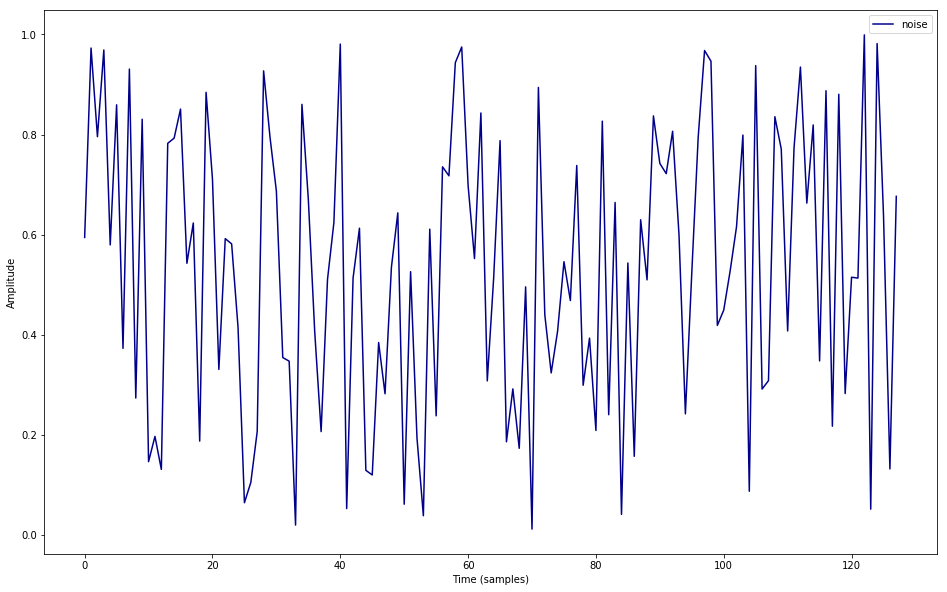

In [124]:
snr_idx = 0
plt.close()
plt.figure(figsize=(16,10))
for i in range(X_test.shape[1]):
    if Y_test[snr_idx,i] == 1:
        plt.plot(X_test[snr_idx,i], color='darkblue', label='noise') 
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        print('This is a noise-only signal')
        break

## Show example of signal + noise

This is a signal+noise signal


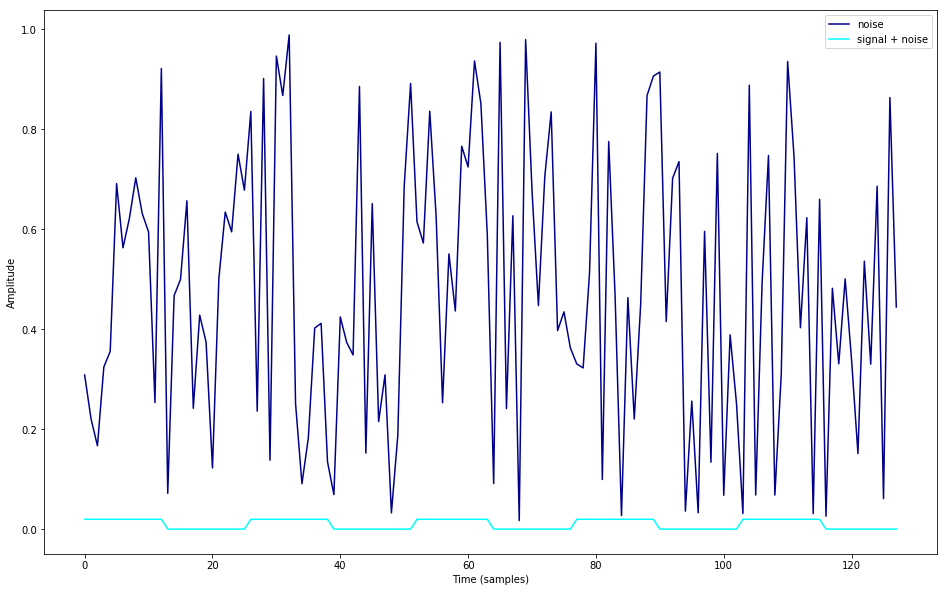

In [123]:
snr_idx = 0
plt.close()
plt.figure(figsize=(16,10))
cnt = 0
for i in range(X_test.shape[1]):
    if Y_test[snr_idx,i] == 0:
        if cnt == 3:
            plt.plot(X_test[snr_idx,i], color='darkblue', label='noise')
            plt.plot(normalize(X_test_noisefree[snr_idx,i]), color='cyan', label='signal + noise')
            plt.xlabel('Time (samples)')
            plt.ylabel('Amplitude')
            plt.legend()
            print('This is a signal+noise signal')
            break
        cnt+=1

# Apply Diehard Statistical Tests

Run Diehard tests on 2 * `test_set_N`, each with 
~1e7 elements in the time series. Diehard tests will output one of three values per 
each test sample PASS (1.0), WEAK PASS (0.5) and FAIL (0.0). Results accross multiple Diehard test for each test sample are averaged. You may choose which Diehard tests to run by editing the `diehard_tests` variable.

In [106]:
# List available Dieharder tests
!dieharder -l

#=============================================================================#
#            dieharder version 3.31.1 Copyright 2003 Robert G. Brown          #
#=============================================================================#
Installed dieharder tests:
 Test Number	                     Test Name	              Test Reliability
  -d 0  	                  Diehard Birthdays Test	      Good
  -d 1  	                     Diehard OPERM5 Test	      Good
  -d 2  	          Diehard 32x32 Binary Rank Test	      Good
  -d 3  	            Diehard 6x8 Binary Rank Test	      Good
  -d 4  	                  Diehard Bitstream Test	      Good
  -d 5  	                            Diehard OPSO	   Suspect
  -d 6  	                       Diehard OQSO Test	   Suspect
  -d 7  	                        Diehard DNA Test	   Suspect
  -d 8  	      Diehard Count the 1s (stream) Test	      Good
  -d 9  	        Diehard Count the 1s Test (byte)	      Good
  -d 10  	                Diehard Parking Lot Te

In [8]:
# Choose diehard tests you'd like to use
diehard_tests = [4]#,6,8,9]#,10,11,15,202]

# Iterate over a predefined number of test samples
for j in range(len(snrs)):
    diehard_results = np.zeros((X_test.shape[0],len(diehard_tests)))
    for i in range(X_test.shape[1]):
    
        # If sample is noise-alone
        if Y_test[j,i] == 1:
            diehard_test_sample = np.random.randint(low=0,high=bit_max_number,size=int(1e7),dtype=np.uint32)
        
        # If sample is signal + noise
        elif Y_test[j,i] == 0:
            signal_choice = np.random.choice(use_signals)
            if signal_choice == 'sineGauss':
                time = np.linspace(-1, 1, int(1e7), endpoint=False)
                sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)
                diehard_test_noisefree_sample = sineGauss
            elif signal_choice == 'sinewave':
                time = np.arange(0,int(1e7),1)
                sinewave = (np.sin(time) + 1)
                diehard_test_noisefree_sample = sinewave
            elif signal_choice == 'squarewave':
                time = np.linspace(0, 1, int(1e7), endpoint=False)
                squarewave = signal.square(2 * np.pi * 5 * time)
                diehard_test_noisefree_sample = squarewave
            noise = np.random.uniform(low=0.0,high=1.0,size=int(1e7))
            diehard_test_sample = snrs[j] * ((diehard_test_noisefree_sample - np.min(diehard_test_noisefree_sample)) / (np.max(diehard_test_noisefree_sample)-np.min(diehard_test_noisefree_sample))) + noise
            norm = np.max(diehard_test_sample)
            diehard_test_sample /= norm
            diehard_test_sample *= bit_max_number
            diehard_test_sample = np.uint32(diehard_test_sample)
    
        # Save test sample to binary file format
        np.save('diehard_results/snr%.8f/test_sample%d' % (snrs[j],i), diehard_test_sample)
    
        # Run diehard tests on sample
        # Can specify to do all tests using -a option
        test_cnt = 0
        for k in diehard_tests:
            results_file_name = 'diehard_results/snr%.8f/test_sample%d.txt' % (snrs[j],i)
            diehard_input_file = 'diehard_results/snr%.8f/test_sample%d.npy' % (snrs[j],i)
            !dieharder -g 201 -d $k -f $diehard_input_file > $results_file_name
    
            # Save results for one test sample to total array
            test = open('diehard_results/snr%.8f/test_sample%d.txt' % (snrs[j],i), 'r+')
            t1 = test.readlines()
            line_cnt = 0
            for t1_line in t1:
                line_cnt +=1
                if line_cnt <= 8:
                    continue
                if line_cnt > 8:
                    if t1_line.split()[-1] == 'PASSED':
                        result_ele = 1.0
                    elif t1_line.split()[-1] == 'FAILED':
                        result_ele = 0.0
                    elif t1_line.split()[-1] == 'WEAK':
                        result_ele = 0.5
                    elif t1_line.split()[0] == '#':
                        continue
            diehard_results[i,test_cnt] = result_ele
            test_cnt += 1
            
#        results_file_name = 'diehard_results/snr%.8f/test_sample%d.txt' % (snrs[j],i)
#        diehard_input_file = 'diehard_results/snr%.8f/test_sample%d.npy' % (snrs[j],i)
#        !dieharder -g 201 -d 0 -f $diehard_input_file > $results_file_name

        # Make last element in each test sample equal to average result
        diehard_results[i,-1] = np.average(diehard_results[i,:])
    
        # remove saved test sample file
        os.remove(diehard_input_file)
        print('Completed Diehard tests on sample %d with snr %.8f' % (i+1,snrs[j]))
        print(diehard_results[i,-1])
        print(Y_test[i])
        
    # Save all Diehard results to one file
    np.save('{0}/SNR{1}/run{2}/diehard_preds.npy'.format(ML_path,snrs[j],run), diehard_results[:,-1])
    np.save('{0}/SNR{1}/run{2}/diehard_targets.npy'.format(ML_path,snrs[j],run), Y_test[j,:])

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 2 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 3 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 4 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 5 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 6 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 7 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 8 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 9 with snr 0.01000000
1.0
0.0
# The file

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 75 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 76 with snr 0.01000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 77 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 78 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 79 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 80 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 81 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 82 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 83 with snr 0.01000000
1.0
0.0
#

Completed Diehard tests on sample 148 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 149 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 150 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 151 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 152 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 153 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 154 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 155 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 156 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 222 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 223 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 224 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 225 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 226 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 227 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 228 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 229 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 230 with snr 0.01000000


Completed Diehard tests on sample 295 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 296 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 297 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 298 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 299 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 300 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 301 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 302 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 303 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 369 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 370 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 371 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 372 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 373 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 374 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 375 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 376 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 377 with snr 0.01000000


Completed Diehard tests on sample 442 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 443 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 444 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 445 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 446 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 447 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 448 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 449 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 450 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 516 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 517 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 518 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 519 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 520 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 521 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 522 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 523 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 524 with snr 0.01000000


Completed Diehard tests on sample 589 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 590 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 591 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 592 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 593 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 594 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 595 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 596 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 597 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 663 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 664 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 665 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 666 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 667 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 668 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 669 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 670 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 671 with snr 0.01000000


Completed Diehard tests on sample 736 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 737 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 738 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 739 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 740 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 741 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 742 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 743 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 744 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 810 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 811 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 812 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 813 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 814 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 815 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 816 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 817 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 818 with snr 0.01000000


Completed Diehard tests on sample 883 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 884 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 885 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 886 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 887 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 888 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 889 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 890 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 891 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 957 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 958 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 959 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 960 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 961 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 962 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 963 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 964 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 965 with snr 0.01000000


# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1030 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1031 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1032 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1033 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1034 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1035 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1036 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1037 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1038 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1103 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1104 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1105 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1106 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1107 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1108 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1109 with snr 0.01000000
0.5
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1110 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1111 with snr 0.

1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1176 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1177 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1178 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1179 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1180 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1181 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1182 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1183 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1184 wit

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1249 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1250 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1251 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1252 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1253 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1254 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1255 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1256 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1257 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1322 with snr 0.01000000
0.5
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1323 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1324 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1325 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1326 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1327 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1328 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1329 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1330 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1395 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1396 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1397 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1398 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1399 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1400 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1401 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1402 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1403 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1468 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1469 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1470 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1471 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1472 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1473 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1474 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1475 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1476 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1541 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1542 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1543 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1544 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1545 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1546 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1547 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1548 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1549 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1614 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1615 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1616 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1617 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1618 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1619 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1620 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1621 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1622 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1687 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1688 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1689 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1690 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1691 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1692 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1693 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1694 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1695 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1760 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1761 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1762 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1763 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1764 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1765 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1766 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1767 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1768 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1833 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1834 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1835 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1836 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1837 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1838 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1839 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1840 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1841 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1906 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1907 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1908 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1909 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1910 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1911 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1912 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1913 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1914 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1979 with snr 0.01000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1980 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1981 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1982 with snr 0.01000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1983 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1984 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1985 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1986 with snr 0.01000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1987 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 55 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 56 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 57 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 58 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 59 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 60 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 61 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 62 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 63 with snr 0.02000000
1.0
1.0
#

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 129 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 130 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 131 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 132 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 133 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 134 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 135 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 136 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 137 with snr 0.02000000


Completed Diehard tests on sample 202 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 203 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 204 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 205 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 206 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 207 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 208 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 209 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 210 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 276 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 277 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 278 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 279 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 280 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 281 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 282 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 283 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 284 with snr 0.02000000


Completed Diehard tests on sample 349 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 350 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 351 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 352 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 353 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 354 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 355 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 356 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 357 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 423 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 424 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 425 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 426 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 427 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 428 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 429 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 430 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 431 with snr 0.02000000


Completed Diehard tests on sample 496 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 497 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 498 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 499 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 500 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 501 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 502 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 503 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 504 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 570 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 571 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 572 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 573 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 574 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 575 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 576 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 577 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 578 with snr 0.02000000


Completed Diehard tests on sample 643 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 644 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 645 with snr 0.02000000
0.5
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 646 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 647 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 648 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 649 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 650 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 651 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 717 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 718 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 719 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 720 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 721 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 722 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 723 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 724 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 725 with snr 0.02000000


Completed Diehard tests on sample 790 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 791 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 792 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 793 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 794 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 795 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 796 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 797 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 798 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 864 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 865 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 866 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 867 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 868 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 869 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 870 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 871 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 872 with snr 0.02000000


Completed Diehard tests on sample 937 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 938 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 939 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 940 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 941 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 942 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 943 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 944 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 945 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1011 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1012 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1013 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1014 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1015 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1016 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1017 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1018 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1019 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1084 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1085 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1086 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1087 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1088 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1089 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1090 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1091 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1092 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1157 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1158 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1159 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1160 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1161 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1162 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1163 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1164 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1165 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1230 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1231 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1232 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1233 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1234 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1235 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1236 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1237 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1238 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1303 with snr 0.02000000
0.5
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1304 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1305 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1306 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1307 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1308 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1309 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1310 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1311 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1376 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1377 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1378 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1379 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1380 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1381 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1382 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1383 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1384 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1449 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1450 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1451 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1452 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1453 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1454 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1455 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1456 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1457 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1522 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1523 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1524 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1525 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1526 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1527 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1528 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1529 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1530 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1595 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1596 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1597 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1598 with snr 0.02000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1599 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1600 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1601 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1602 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1603 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1668 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1669 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1670 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1671 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1672 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1673 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1674 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1675 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1676 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1741 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1742 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1743 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1744 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1745 with snr 0.02000000
1.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1746 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1747 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1748 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1749 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1814 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1815 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1816 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1817 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1818 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1819 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1820 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1821 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1822 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1887 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1888 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1889 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1890 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1891 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1892 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1893 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1894 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1895 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1960 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1961 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1962 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1963 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1964 with snr 0.02000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1965 with snr 0.02000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1966 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1967 with snr 0.02000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1968 with snr 0.

Completed Diehard tests on sample 35 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 36 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 37 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 38 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 39 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 40 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 41 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 42 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 43 with snr 0.03000000
0.5
1.0
# The file file_input_raw was rewound 3 times
C

Completed Diehard tests on sample 109 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 110 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 111 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 112 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 113 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 114 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 115 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 116 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 117 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 183 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 184 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 185 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 186 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 187 with snr 0.03000000
0.5
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 188 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 189 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 190 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 191 with snr 0.03000000


Completed Diehard tests on sample 256 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 257 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 258 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 259 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 260 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 261 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 262 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 263 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 264 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 330 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 331 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 332 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 333 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 334 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 335 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 336 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 337 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 338 with snr 0.03000000


Completed Diehard tests on sample 403 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 404 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 405 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 406 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 407 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 408 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 409 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 410 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 411 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 477 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 478 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 479 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 480 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 481 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 482 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 483 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 484 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 485 with snr 0.03000000


Completed Diehard tests on sample 550 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 551 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 552 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 553 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 554 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 555 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 556 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 557 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 558 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 624 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 625 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 626 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 627 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 628 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 629 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 630 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 631 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 632 with snr 0.03000000


Completed Diehard tests on sample 697 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 698 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 699 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 700 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 701 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 702 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 703 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 704 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 705 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 771 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 772 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 773 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 774 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 775 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 776 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 777 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 778 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 779 with snr 0.03000000


Completed Diehard tests on sample 844 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 845 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 846 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 847 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 848 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 849 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 850 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 851 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 852 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 918 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 919 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 920 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 921 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 922 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 923 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 924 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 925 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 926 with snr 0.03000000


Completed Diehard tests on sample 991 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 992 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 993 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 994 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 995 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 996 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 997 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 998 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 999 with snr 0.03000000
0.5
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1064 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1065 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1066 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1067 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1068 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1069 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1070 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1071 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1072 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1137 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1138 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1139 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1140 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1141 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1142 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1143 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1144 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1145 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1210 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1211 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1212 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1213 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1214 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1215 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1216 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1217 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1218 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1283 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1284 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1285 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1286 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1287 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1288 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1289 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1290 with snr 0.03000000
0.5
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1291 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1356 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1357 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1358 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1359 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1360 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1361 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1362 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1363 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1364 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1429 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1430 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1431 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1432 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1433 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1434 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1435 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1436 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1437 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1502 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1503 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1504 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1505 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1506 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1507 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1508 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1509 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1510 with snr 0.

Completed Diehard tests on sample 1574 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1575 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1576 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1577 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1578 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1579 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1580 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1581 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1582 with snr 0.03000000
0.0
0.0
# The file file_input_raw was

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1647 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1648 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1649 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1650 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1651 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1652 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1653 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1654 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1655 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1720 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1721 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1722 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1723 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1724 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1725 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1726 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1727 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1728 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1793 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1794 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1795 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1796 with snr 0.03000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1797 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1798 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1799 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1800 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1801 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1866 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1867 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1868 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1869 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1870 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1871 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1872 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1873 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1874 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1939 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1940 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1941 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1942 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1943 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1944 with snr 0.03000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1945 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1946 with snr 0.03000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1947 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 14 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 15 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 16 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 17 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 18 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 19 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 20 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 21 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 22 with snr 0.04000000
1.0
1.0
#

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 88 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 89 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 90 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 91 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 92 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 93 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 94 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 95 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 96 with snr 0.04000000
0.0
0.0
#

Completed Diehard tests on sample 161 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 162 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 163 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 164 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 165 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 166 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 167 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 168 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 169 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 235 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 236 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 237 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 238 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 239 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 240 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 241 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 242 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 243 with snr 0.04000000


Completed Diehard tests on sample 308 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 309 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 310 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 311 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 312 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 313 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 314 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 315 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 316 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 382 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 383 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 384 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 385 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 386 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 387 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 388 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 389 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 390 with snr 0.04000000


Completed Diehard tests on sample 455 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 456 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 457 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 458 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 459 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 460 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 461 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 462 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 463 with snr 0.04000000
0.5
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 529 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 530 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 531 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 532 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 533 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 534 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 535 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 536 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 537 with snr 0.04000000


Completed Diehard tests on sample 602 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 603 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 604 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 605 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 606 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 607 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 608 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 609 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 610 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 676 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 677 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 678 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 679 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 680 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 681 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 682 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 683 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 684 with snr 0.04000000


Completed Diehard tests on sample 749 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 750 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 751 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 752 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 753 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 754 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 755 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 756 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 757 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 823 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 824 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 825 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 826 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 827 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 828 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 829 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 830 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 831 with snr 0.04000000


Completed Diehard tests on sample 896 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 897 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 898 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 899 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 900 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 901 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 902 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 903 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 904 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 970 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 971 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 972 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 973 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 974 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 975 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 976 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 977 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 978 with snr 0.04000000


# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1043 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1044 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1045 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1046 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1047 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1048 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1049 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1050 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1051 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1116 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1117 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1118 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1119 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1120 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1121 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1122 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1123 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1124 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1189 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1190 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1191 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1192 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1193 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1194 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1195 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1196 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1197 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1262 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1263 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1264 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1265 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1266 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1267 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1268 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1269 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1270 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1335 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1336 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1337 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1338 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1339 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1340 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1341 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1342 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1343 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1408 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1409 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1410 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1411 with snr 0.04000000
0.5
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1412 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1413 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1414 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1415 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1416 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1481 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1482 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1483 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1484 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1485 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1486 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1487 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1488 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1489 with snr 0.

1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1554 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1555 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1556 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1557 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1558 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1559 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1560 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1561 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1562 wit

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1627 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1628 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1629 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1630 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1631 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1632 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1633 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1634 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1635 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1700 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1701 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1702 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1703 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1704 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1705 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1706 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1707 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1708 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1773 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1774 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1775 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1776 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1777 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1778 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1779 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1780 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1781 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1846 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1847 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1848 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1849 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1850 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1851 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1852 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1853 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1854 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1919 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1920 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1921 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1922 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1923 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1924 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1925 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1926 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1927 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1992 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1993 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1994 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1995 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1996 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1997 with snr 0.04000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1998 with snr 0.04000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 2 with snr 0.050000

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 68 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 69 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 70 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 71 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 72 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 73 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 74 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 75 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 76 with snr 0.05000000
0.0
0.0
#

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 142 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 143 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 144 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 145 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 146 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 147 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 148 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 149 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 150 with snr 0.05000000


Completed Diehard tests on sample 215 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 216 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 217 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 218 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 219 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 220 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 221 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 222 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 223 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 289 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 290 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 291 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 292 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 293 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 294 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 295 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 296 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 297 with snr 0.05000000


Completed Diehard tests on sample 362 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 363 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 364 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 365 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 366 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 367 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 368 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 369 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 370 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 436 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 437 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 438 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 439 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 440 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 441 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 442 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 443 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 444 with snr 0.05000000


Completed Diehard tests on sample 509 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 510 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 511 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 512 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 513 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 514 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 515 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 516 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 517 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 583 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 584 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 585 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 586 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 587 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 588 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 589 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 590 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 591 with snr 0.05000000


Completed Diehard tests on sample 656 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 657 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 658 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 659 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 660 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 661 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 662 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 663 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 664 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 730 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 731 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 732 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 733 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 734 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 735 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 736 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 737 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 738 with snr 0.05000000


Completed Diehard tests on sample 803 with snr 0.05000000
0.5
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 804 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 805 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 806 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 807 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 808 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 809 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 810 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 811 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 877 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 878 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 879 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 880 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 881 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 882 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 883 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 884 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 885 with snr 0.05000000


Completed Diehard tests on sample 950 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 951 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 952 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 953 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 954 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 955 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 956 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 957 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 958 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 

Completed Diehard tests on sample 1023 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1024 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1025 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1026 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1027 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1028 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1029 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1030 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1031 with snr 0.05000000
1.0
1.0
# The file file_input_raw was

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1096 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1097 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1098 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1099 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1100 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1101 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1102 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1103 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1104 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1169 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1170 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1171 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1172 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1173 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1174 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1175 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1176 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1177 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1242 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1243 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1244 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1245 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1246 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1247 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1248 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1249 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1250 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1315 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1316 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1317 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1318 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1319 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1320 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1321 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1322 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1323 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1388 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1389 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1390 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1391 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1392 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1393 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1394 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1395 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1396 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1461 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1462 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1463 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1464 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1465 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1466 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1467 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1468 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1469 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1534 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1535 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1536 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1537 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1538 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1539 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1540 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1541 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1542 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1607 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1608 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1609 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1610 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1611 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1612 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1613 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1614 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1615 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1680 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1681 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1682 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1683 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1684 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1685 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1686 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1687 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1688 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1753 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1754 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1755 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1756 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1757 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1758 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1759 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1760 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1761 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1826 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1827 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1828 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1829 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1830 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1831 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1832 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1833 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1834 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1899 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1900 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1901 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1902 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1903 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1904 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1905 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1906 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1907 with snr 0.

# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1972 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1973 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1974 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1975 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1976 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1977 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1978 with snr 0.05000000
1.0
1.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1979 with snr 0.05000000
0.0
0.0
# The file file_input_raw was rewound 3 times
Completed Diehard tests on sample 1980 with snr 0.

# Train and Test ML Model

## Option to load network model

In [26]:
model = load_model('trained_model/model.h5')

## Define network model

In [239]:
# Define network hyperparameters
lstm_out = 100
batch_size = 64

model = Sequential()


# CNN-LSTM network
model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_out))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


"""
# Simple fully-connected network
model.add(Dense(128, input_dim=bitstream_len, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
"""


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

## Train and save model

In [240]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size = batch_size, epochs = 2,  verbose = 1)

Train on 95000 samples, validate on 5000 samples
Epoch 1/2
95000/95000 [==============================] - 145s 2ms/step - loss: 0.2063 - acc: 0.8992 - val_loss: 0.0506 - val_acc: 0.9830
Epoch 2/2
95000/95000 [==============================] - 147s 2ms/step - loss: 0.0781 - acc: 0.9704 - val_loss: 0.0732 - val_acc: 0.9750


In [241]:
model.save('trained_model/model.h5')

## Evaluate model

Evaluate the accuracy on a unique test set which has 
not been used during either the training or the validation phase. 
Only look at the first N elements of sequences (same length as that 
used during training).

In [244]:
for i in range(len(snrs)):
    score,acc = model.evaluate(X_test[i]/bit_max_number,Y_test[i],batch_size=batch_size,verbose=2)
    print("Score: %.2f at snr %.8f" % (score,snrs[i]))
    print("Validation Accuracy: %.2f at snr %.8f" % (acc,snrs[i]))
    
    # Make predictions
    preds = model.predict(X_test[i]/bit_max_number)
    targets = Y_test[i,:]

    # Save model predictions
    np.save('{0}/SNR{1}/run{2}/targets.npy'.format(ML_path,snrs[i],run), targets)
    np.save('{0}/SNR{1}/run{2}/preds.npy'.format(ML_path,snrs[i],run), preds)

Score: 0.04 at snr 0.01000000
Validation Accuracy: 0.99 at snr 0.01000000
Score: 7.99 at snr 0.02000000
Validation Accuracy: 0.49 at snr 0.02000000
Score: 7.99 at snr 0.03000000
Validation Accuracy: 0.49 at snr 0.03000000
Score: 8.00 at snr 0.04000000
Validation Accuracy: 0.49 at snr 0.04000000
Score: 7.99 at snr 0.05000000
Validation Accuracy: 0.49 at snr 0.05000000


## Results plots

Plots illustrating the robustness of the model.

In [63]:
def CNN_ROC(ml_path, snr, run, network_type, num_test):
    """
    calculate roc curve for machine learning results
    """
    if network_type == 'ML':
        targets = np.load('{0}/SNR{1}/run{2}/targets.npy'.format(ml_path,snr,run))
        preds = np.load('{0}/SNR{1}/run{2}/preds.npy'.format(ml_path,snr,run))
        targets, preds = targets[:num_test], preds[:num_test,:]
    elif network_type == 'diehard':
        targets = np.load('{0}/SNR{1}/run{2}/diehard_targets.npy'.format(ml_path,snr,run))
        preds = np.load('{0}/SNR{1}/run{2}/diehard_preds.npy'.format(ml_path,snr,run))
        targets, preds = targets[:num_test], preds[:num_test]
    assert len(preds) == len(targets)
    FDP, TDP, _ = metrics.roc_curve(targets, preds)
    FDP_error = [sigma(len(targets)/2., t) for t in FDP]
    TDP_error = [sigma(len(targets)/2., t) for t in TDP]
    return FDP, TDP, FDP_error, TDP_error

In [64]:
def sigma(n, tp):
    """ Computes standard deviation
    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

In [65]:
def accuracy(FDP,TDP,TDP_error, threshold):
    """
    calculate accuracy(efficiency) given fdp and tdp
    """
    fx = interpolate.interp1d(FDP,TDP)
    fx_e_neg = interpolate.interp1d(FDP,TDP-TDP_error)
    fx_e_pos = interpolate.interp1d(FDP,TDP+TDP_error)
    acc = fx(threshold)
    acc_e_neg = fx_e_neg(threshold)
    acc_e_pos = fx_e_pos(threshold)
    return acc, acc_e_neg, acc_e_pos

In [66]:
def interp_sig(snr, tdp, threshold, c, snrs):
    """
    use spline interpolation to fit a line
    uses sigmoid to map (0,1) to (-inf, inf) and vice-versa
    :param snr:
    :param rho:
    :param threshold:
    :param snrs: list of snrs
    :return:
    """
    # assume start with NaN
    flag = True
    while flag:
        snr_new, tdp_new = interp_loop(snr, tdp, threshold, c, snrs)
        if not np.isnan(tdp_new).any():
            flag = False
        else:
            snr = snr[1:]
            tdp = tdp[1:]

    if np.isnan(tdp_new).any():
        print('Failed to avoid NaNs')

    return snr_new, tdp_new

In [67]:
def interp_loop(snr, tdp, threshold, c, snrs):
    """
    function to loop over to peform spline interpolation
    :param snr:
    :param rho:
    :param threshold:
    :param c: fuzzfactor
    :param snrs: list of snr values
    """
    # find min value
    min_tdp = np.min(tdp)
    # take log of data to avoid negative values
    tmp_tdp = special.logit(tdp - min_tdp + c)
    # interpolate with spline interpolation
    print(snr,tmp_tdp)
    tck = interpolate.splrep(snr, tmp_tdp)
    # new x and y values
    snr_new = np.linspace(snrs[0], snrs[-1], 1e3)
    tmp_tdp_new = interpolate.splev(snr_new, tck, der=0)
    # return to linear space
    tdp_new = special.expit(tmp_tdp_new) + min_tdp - c

    return snr_new, tdp_new

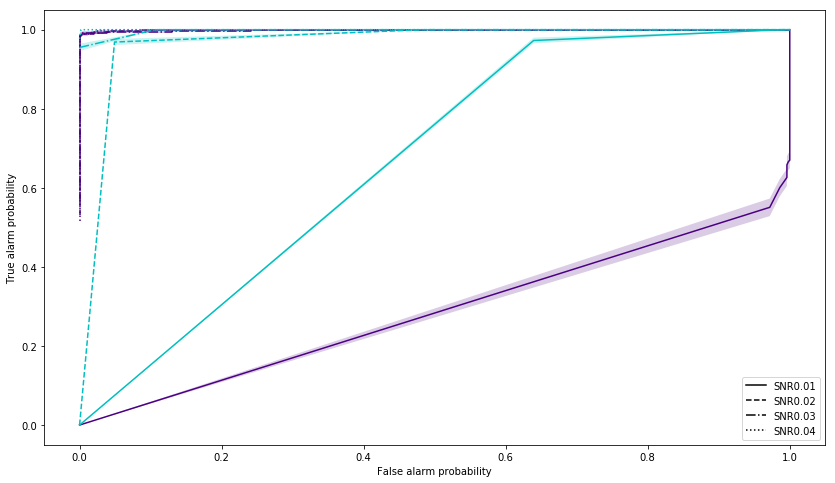

In [210]:
# Make TAP/FAP figure

# empty lists to populate
MF_ROCs = []
CNN_ROCs = []
MF_acc = []
CNN_acc = []

# plot roc curves
fig1 = plt.figure(figsize=(14,8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_rasterization_zorder(1)

# colours and line styles for plots
colours = ['indigo', 'c', 'darkorange', 'indigo', 'c', 'darkorange', 'indigo', 'c', 'darkorange']
linestyles = ['-', '--', '-.', ':']

lineArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-')
dashArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--')
dashdotArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-.')
dotArtist = plt.Line2D((0,1), (0, 0), color = 'k', linestyle = ':')
c1Artist = plt.Line2D((0, 1), (0, 0), color=colours[0], linestyle='', marker='o')
c2Artist = plt.Line2D((0, 1), (0, 0), color=colours[1], linestyle='', marker='o')
c3Artist = plt.Line2D((0, 1), (0, 0), color=colours[2], linestyle='', marker='o')

# handles for different plots
handles = [lineArtist, dashArtist, dashdotArtist,dotArtist]
acc_handles = [c1Artist, c2Artist, lineArtist, dashArtist, dashdotArtist]
ROC_labels = ['SNR0.01', 'SNR0.02', 'SNR0.03', 'SNR0.04']
acc_labels = ['CNN', 'Diehard', 'FAP = 0.1', 'FAP = 0.01', 'FAP = 0.001']

# calcualte ROC curves and accuracy
for snr, run in zip(snrs, runs):
    FDP, TDP, FDP_error, TDP_error = CNN_ROC(ML_path, snr, run, 'ML', test_set_N)
    CNN_ROCs.append([FDP, TDP, FDP_error, TDP_error])
    CNN_acc.append([accuracy(FDP, TDP, TDP_error, t) for t in thresholds])
    
    FDP, TDP, FDP_error, TDP_error = CNN_ROC(ML_path, snr, run, 'diehard', test_set_N)
    MF_ROCs.append([FDP, TDP, FDP_error, TDP_error])
    MF_acc.append([accuracy(FDP, TDP, TDP_error, t) for t in thresholds])

for i, d in enumerate([CNN_ROCs[n] for n in to_plot]):
    ax1.plot(d[0], d[1], c=colours[0], linestyle=linestyles[i], label='CNN snr {0}'.format(snrs[i]))
    ax1.fill_between(d[0], d[1]+d[3], d[1]-d[3], alpha=0.2, facecolor=colours[0], zorder=0)
    
for i, d in enumerate([MF_ROCs[n] for n in to_plot]):
    ax1.plot(d[0], d[1], c=colours[1], linestyle=linestyles[i], label='Diehard snr {0}'.format(snrs[i]))
    ax1.fill_between(d[0], d[1]+d[3], d[1]-d[3], alpha=0.2, facecolor=colours[1], zorder=0)
    
ax1.set_xlabel('False alarm probability')
ax1.set_ylabel('True alarm probability')
#ax1.set_xscale('log')
#ax1.set_yscale('log')
#ax1.set_xlim(1e-4, 1)
#ax1.set_ylim(1e-4, 1)
ax1.legend(handles, ROC_labels)

In [363]:
CNN_acc

[[(array(0.57393384), array(0.56404377), array(0.58382391)),
  (array(0.38168194), array(0.37196597), array(0.39139792)),
  (array(0.28886648), array(0.27980249), array(0.29793047))],
 [(array(0.52157035), array(0.51157966), array(0.53156104)),
  (array(0.33030291), array(0.32089647), array(0.33970935)),
  (array(0.24579992), array(0.23718998), array(0.25440986))],
 [(array(0.54204862), array(0.53208405), array(0.5520132)),
  (array(0.28656835), array(0.27752519), array(0.29561152)),
  (array(0.19968115), array(0.19168593), array(0.20767636))],
 [(array(0.38939817), array(0.37964589), array(0.39915044)),
  (array(0.18174572), array(0.17403302), array(0.18945841)),
  (array(0.14004902), array(0.13310867), array(0.14698938))],
 [(array(0.30833798), array(0.29910184), array(0.31757412)),
  (array(0.12275807), array(0.11619488), array(0.12932126)),
  (array(0.07732164), array(0.07197962), array(0.08266366))]]

In [377]:
snr=1e-2
preds = np.load('{0}/SNR{1}/run{2}/diehard_preds.npy'.format(ML_path,snr,run))
targets = np.load('{0}/SNR{1}/run{2}/diehard_targets.npy'.format(ML_path,snr,run))
cnt = 0
for i in range(preds.shape[0]):
    if preds[i] == targets[i]:
        cnt+=1

FileNotFoundError: [Errno 2] No such file or directory: './results_files/SNR0.01/run1/diehard_preds.npy'

[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233  2.78474942  2.71438209  2.78474942 -1.89989549]
[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233  1.52147164  1.70051637  1.72184698  1.72184698]
[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233  1.67982331  4.32049821  4.05172588 -4.29432866]
[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233 -1.50107111  2.83580995  4.20417797  4.20417797]
[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233  0.94409944  1.69585794  1.6071609  -6.32028245]
[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233 -3.96163162  3.04297728  4.32805932  6.88562368]


/home/hunter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/hunter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


(0, 1)

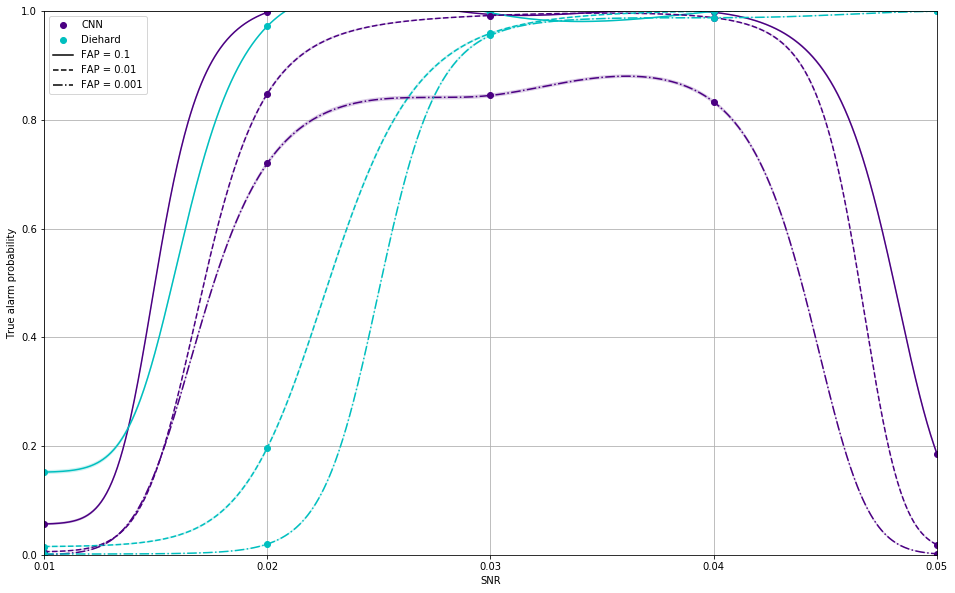

In [211]:
# Make efficiency curve
fig2 = plt.figure(figsize=(16,10))
ax2 = fig2.add_subplot(1, 1, 1, )
ax2.set_rasterization_zorder(1)

# fuzz factors for each thresholds
ffs = [0.5e-3, 0.5e-3, 0.5e-3]

for i in range(len(thresholds)):
    # points to plot
    cnn = np.asarray([a[i][0] for a in CNN_acc])
    # line fit
    snr_cnn, eff_cnn = interp_sig(snrs, cnn, thresholds[i], ffs[i], snrs)
    
    # points to plot
    mf = np.asarray([a[i][0] for a in MF_acc])
    # line fit
    snr_mf, eff_mf = interp_sig(snrs, mf, thresholds[i], ffs[1], snrs)

    # errors
    d_eff_cnn = [sigma(1e4, e) for e in eff_cnn]
    d_eff_mf = [sigma(1e4, e) for e in eff_mf]

    # plot points for cnn
    ax2.plot(snrs, cnn, c=colours[0], marker = 'o', linestyle='')
    # plot line fit for cnn
    ax2.plot(snr_cnn, eff_cnn, c=colours[0], linestyle=linestyles[i])
    # plot error region for cnn
    ax2.fill_between(snr_cnn, eff_cnn - d_eff_cnn , eff_cnn + d_eff_cnn, facecolor=colours[0], alpha=0.2, zorder=0)

    
    # plot points for mf
    ax2.plot(snrs, mf, c=colours[1], marker = 'o', linestyle='',)
    # plot line fit for mf
    ax2.plot(snr_mf, eff_mf, c=colours[1], linestyle=linestyles[i])
    # plot error region for mf
    ax2.fill_between(snr_mf, eff_mf - d_eff_mf, eff_mf + d_eff_mf, facecolor=colours[1], alpha=0.2, zorder=0)
    

#ax2.legend(acc_handles, acc_labels)
ax2.legend(acc_handles, acc_labels)
ax2.set_xticks(snrs)
ax2.grid()
ax2.set_xlabel('SNR')
ax2.set_ylabel('True alarm probability')
ax2.set_xlim(snrs[0], snrs[-1])
ax2.set_ylim(0, 1)